# Introduction to Decision Trees

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

||continuous|categorical|
|---|---|---|
|**supervised**|**regression**|**classification**|
|**unsupervised**|dimension reduction|clustering|

## Regression trees

Let's look at a simple example to motivate our learning.

Our goal is to **predict a baseball player's Salary** based on **Years** (number of years playing in the major leagues) and **Hits** (number of hits he made in the previous year). Here is the training data, represented visually (low salary is blue/green, high salary is red/yellow):

<img src="Images/15_salary_color.png">

**How might you "stratify" or "segment" the feature space into regions, based on salary?** Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

Below is a regression tree that has been fit to the data by a computer. (We will talk later about how the fitting algorithm actually works.) Note that  Salary is measured in thousands and has been log-transformed.

<img src="Images/15_salary_tree.png">

**How do we make Salary predictions (for out-of-sample data) using a decision tree?**

- Start at the top, and examine the first "splitting rule" (Years < 4.5).
- If the rule is True for a given player, follow the left branch. If the rule is False, follow the right branch.
- Continue until reaching the bottom. The predicted Salary is the number in that particular "bucket".
- *Side note:* Years and Hits are both integers, but the convention is to label these rules using the midpoint between adjacent values.

Examples predictions:

- Years=3, then predict 5.11 ($\$1000 \times e^{5.11} \approx \$166000$)
- Years=5 and Hits=100, then predict 6.00 ($\$1000 \times e^{6.00} \approx \$403000$)
- Years=8 and Hits=120, then predict 6.74 ($\$1000 \times e^{6.74} \approx \$846000$)

**How did we come up with the numbers at the bottom of the tree?** Each number is just the **mean Salary in the training data** of players who fit that criteria. Here's the same diagram as before, split into the three regions:

<img src="Images/15_salary_regions.png">

This diagram is essentially a combination of the two previous diagrams (except that the observations are no longer color-coded). In $R_1$, the mean log Salary was 5.11. In $R_2$, the mean log Salary was 6.00. In $R_3$, the mean log Salary was 6.74. Thus, those values are used to predict out-of-sample data.

Let's introduce some terminology:

<img src="Images/15_salary_tree_annotated.png">

**How might you interpret the "meaning" of this tree?**

- Years is the most important factor determining Salary, with a lower number of Years corresponding to a lower Salary.
- For a player with a lower number of Years, Hits is not an important factor determining Salary.
- For a player with a higher number of Years, Hits is an important factor determining Salary, with a greater number of Hits corresponding to a higher Salary.

What we have seen so far hints at the advantages and disadvantages of decision trees:

**Advantages:**

- Highly interpretable
- Can be displayed graphically
- Prediction is fast

**Disadvantages:**

- Predictive accuracy is not as high as some supervised learning methods
- Can easily overfit the training data (high variance)

## Building a regression tree by hand

How do you build a decision tree? You're going to find out by building one!

Your training data is a tiny dataset of [used vehicle sale prices](https://raw.githubusercontent.com/justmarkham/DAT4/master/data/used_vehicles.csv). Your goal is to predict Price for out-of-sample data. Here are your instructions:

- Read the data into Pandas.
- Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
- Decide which feature is the most important predictor, and use that to make your first split. (Only binary splits are allowed!)
- After making your first split, you should actually split your data in Pandas into two parts, and then explore each part to figure out what other splits to make.
- Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting. (As always, your goal is to build a model that generalizes well!)
- You are allowed to split on the same variable multiple times!
- Draw your tree, making sure to label your leaves with the mean Price for the observations in that "bucket".
- When you're finished, review your tree to make sure nothing is backwards. (Remember: follow the left branch if the rule is true, and follow the right branch if the rule is false.)

## How does a computer build a regression tree?

The ideal approach would be for the computer to consider every possible partition of the feature space. However, this is computationally infeasible, so instead an approach is used called **recursive binary splitting:**

- Begin at the top of the tree.
- For every single predictor, examine every possible cutpoint, and choose the predictor and cutpoint such that the resulting tree has the **lowest possible mean squared error (MSE)**. Make that split.
- Repeat the examination for the two resulting regions, and again make a single split (in one of the regions) to minimize the MSE.
- Keep repeating this process until a stopping criteria is met.

**How does it know when to stop?**

1. We could define a stopping criterion, such as a **maximum depth** of the tree or the **minimum number of samples in the leaf**.
2. We could grow the tree deep, and then "prune" it back using a method such as "cost complexity pruning" (aka "weakest link pruning").

Method 2 involves setting a tuning parameter that penalizes the tree for having too many leaves. As the parameter is increased, branches automatically get pruned from the tree, resulting in smaller and smaller trees. The tuning parameter can be selected through cross-validation.

Note: **Method 2 is not currently supported by scikit-learn**, and so we will use Method 1 instead.

Here's an example of an **unpruned tree**, and a comparison of the training, test, and cross-validation errors for trees with different numbers of leaves:

<img src="Images/15_salary_unpruned.png">

As you can see, the **training error** continues to go down as the tree size increases, but the lowest **cross-validation error** occurs for a tree with 3 leaves.

## Building a regression tree in scikit-learn

In [3]:
# import pandas
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

# read in vehicle data
vehicles = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/used_vehicles.csv')

# print out data
vehicles

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car


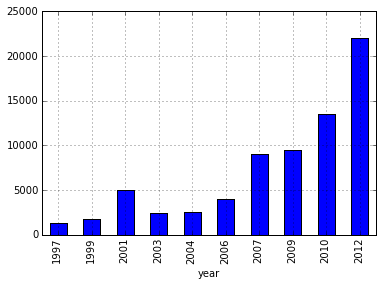

In [5]:
vehicles.groupby('year').price.mean().plot(kind='bar')

In [6]:
vehicles[vehicles.year >= 2007]

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car


In [8]:
vehicles[vehicles.year < 2007]

,price,year,miles,doors,type
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car
10,2500,2003,190000,2,truck
11,5000,2001,62000,4,car
12,1800,1999,163000,2,truck
13,1300,1997,138000,4,car


In [12]:
vehicles.miles.mean()

114464.28571428571

### split at 35,0000

In [33]:
MP1=vehicles[(vehicles.year >= 2007) & (vehicles.miles < 35000)].price.mean()
MP1

18000.0

In [34]:
MP2=vehicles[(vehicles.year >= 2007) & (vehicles.miles > 35000)].price.mean()
MP2

10500.0

### split at 50,000

In [46]:
MP1_V2=vehicles[(vehicles.year >= 2007) & (vehicles.miles < 50000)].price.mean()
MP1_V2

15000.0

In [48]:
MP2_V2=vehicles[(vehicles.year >= 2007) & (vehicles.miles > 50000)].price.mean()
MP2_V2

11250.0

In [26]:
vehicles[(vehicles.year < 2007)]

,price,year,miles,doors,type
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car
10,2500,2003,190000,2,truck
11,5000,2001,62000,4,car
12,1800,1999,163000,2,truck
13,1300,1997,138000,4,car


### Entropy

### MSE V-1

In [32]:
vehicles[(vehicles.year >= 2007) & (vehicles.miles < 35000)].price

0    22000
1    14000
Name: price, dtype: int64

In [35]:
MSE1 = sum((vehicles[(vehicles.year >= 2007) & (vehicles.miles < 35000)].price-MP1) **2)
MSE1

32000000.0

In [37]:
MSE2 = sum((vehicles[(vehicles.year >= 2007) & (vehicles.miles > 35000)].price-MP2)**2)
MSE2

9500000.0

In [45]:
totalMSE_V1= MSE1+MSE2
totalMSE_V1

120250000.0

### MSE V-2

In [40]:
vehicles[(vehicles.year >= 2007) & (vehicles.miles > 50000)].price

2    13000
3     9500
Name: price, dtype: int64

In [49]:
MSE1 = sum((vehicles[(vehicles.year >= 2007) & (vehicles.miles < 50000)].price-MP1_V2) **2)
MSE1

86000000.0

In [50]:
MSE2 = sum((vehicles[(vehicles.year >= 2007) & (vehicles.miles > 50000)].price-MP2_V2)**2)
MSE2

6125000.0

In [51]:
MSE1+MSE2

92125000.0

### Conclusion: 35,000 is the better split

In [52]:
vehicles(vechiles.year<2007)

NameError: name 'vechiles' is not defined

In [3]:
# convert car to 0 and truck to 1
vehicles['type'] = vehicles.type.map({'car':0, 'truck':1})

In [4]:
# select feature columns (every column except for the 0th column)
feature_cols = vehicles.columns[1:]

# define X (features) and y (response)
X = vehicles[feature_cols]
y = vehicles.price

In [5]:
# split into train/test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [6]:
# print out each of the arrays
print X_train
print y_train
print X_test
print y_test

[[  2003 190000      2      1]
 [  2007  47000      4      0]
 [  2010  30000      2      0]
 [  1999 163000      2      1]
 [  2012  13000      2      0]
 [  1997 138000      4      0]
 [  2003 160000      4      0]
 [  2003 138000      2      0]
 [  2001  62000      4      0]
 [  2006 124000      2      0]]
[ 2500  9000 14000  1800 22000  1300  1900  3000  5000  4000]
[[  2009  78000      4      0]
 [  2004 209000      4      1]
 [  2004 177000      4      0]
 [  2010  73500      4      0]]
[ 9500  2000  3000 13000]


In [7]:
# import class, instantiate estimator, fit with training set
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(compute_importances=None, criterion='mse',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           random_state=1, splitter='best')

In [8]:
# make predictions
preds = treereg.predict(X_test)

# print predictions and actual values
print preds
print y_test

[ 5000.  1900.  1900.  5000.]
[ 9500  2000  3000 13000]


Take a minute to discuss Root Mean Squared Error [RMSE](https://www.kaggle.com/wiki/RootMeanSquaredError)


In [20]:
# print RMSE
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(y_test, preds))

4622.4993239588475

In [21]:
# use cross-validation to find best max_depth
from sklearn.cross_validation import cross_val_score

In [22]:
# try max_depth=2
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4804.3767888427128

In [23]:

scores

array([ -1.12050000e+08,  -5.75850000e+06,  -2.03940000e+06])

 Note that we did a -scores in the previous statement. This is because scikit reports mean square error as negative. Some debate/discussions on why the score is negative:
 https://github.com/scikit-learn/scikit-learn/issues/2439

In [24]:
# try max_depth=3
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4592.1554255755254

In [25]:
# try max_depth=4
treereg = DecisionTreeRegressor(max_depth=4, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4704.0052694797387

In [26]:
# max_depth=3 was best, so fit a tree using that parameter with ALL DATA
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=3,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=1,
           splitter='best')

In [27]:
# compute the "Gini importance" of each feature: the (normalized) total reduction of MSE brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,type,0.000000


### Installing Graphviz (optional):
* Mac:
    * option 1: [Download and install PKG file](http://www.graphviz.org/Download_macos.php)
    * option 2: run the code block below
* Windows:
     [Download and install MSI file](http://www.graphviz.org/Download_windows.php)
     * Add it to your Path: Go to Control Panel, System, Advanced System Settings, Environment Variables. Under system 
       variables,edit "Path" to include the path to the "bin" folder, such as: C:\Program Files (x86)\Graphviz2.38\bin

In [18]:
### for mac os x only
!ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
!brew install libtool
!brew install graphviz

It appears Homebrew is already installed. If your intent is to reinstall you
should do the following before running this installer again:
    rm -rf /usr/local/Cellar /usr/local/.git && brew cleanup


In [19]:
# create a Graphviz file
from sklearn.tree import export_graphviz
with open("Images/15_vehicles.dot", 'wb') as f:
    f = export_graphviz(treereg, out_file=f, feature_names=feature_cols)

# at the command line, run this to convert to PNG:
# dot -Tpng 15_vehicles.dot -o 15_vehicles.png

<img src="Images/15_vehicles.png">

## Interpreting a tree diagram

How do we read this decision tree?

**Internal nodes:**

- "samples" is the number of observations in that node before splitting
- "mse" is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- first line is the condition used to split that node (go left if true, go right if false)

**Leaves:**

- "samples" is the number of observations in that node
- "value" is the mean response value in that node
- "mse" is the mean squared error calculated by comparing the actual response values in that node against "value"

## Predicting for out-of-sample data

How accurate is scikit-learn's regression tree at predicting the out-of-sample data?

In [28]:
# read in out-of-sample data
oos = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/used_vehicles_oos.csv')

# convert car to 0 and truck to 1
oos['type'] = oos.type.map({'car':0, 'truck':1})

# print data
oos

,price,year,miles,doors,type
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [29]:
# define X and y
X_oos = oos[feature_cols]
y_oos = oos.price

In [30]:
# make predictions on out-of-sample data
preds = treereg.predict(X_oos)

# print predictions and actual values
print preds
print y_oos.values

[  4000.   5000.  13500.]
[ 3000  6000 12000]


In [31]:
# print RMSE
np.sqrt(metrics.mean_squared_error(y_oos, preds))

1190.2380714238084

## Classification trees

Classification trees are very similar to regression trees. Here is a quick comparison:

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize a different criterion (discussed below)|

Note that classification trees easily handle **more than two response classes**! (How have other classification models we've seen handled this scenario?)

Here's an **example of a classification tree**, which predicts whether or not a patient who presented with chest pain has heart disease:

<img src="Images/15_heart_tree.png">

## Splitting criteria for classification trees

Here are common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region. It basically tries to classify the most frequent class first and then the rest. 
- **Entropy:** It uses logarithms. The basic idea is generally to have a split of dataset into 50:50 at each level. Try to understand how it is different from Gini. Look at the reference [here](https://www.salford-systems.com/resources/whitepapers/114-do-splitting-rules-really-matter)

Which to use?

- When growing a tree with 2-3 target labels,  Gini index is probably the best (Default for scikit learn)
- When growing a tree with 4-9 target labels,  Entropy has worked bettter in many cases index is probably the best. 
- When pruning a tree, classification error rate is preferable in order to maximize predictive accuracy.



## Handling categorical predictors

Some implementations of classification trees will allow you to handle categorical predictors **without creating dummy variables**. When splitting on a categorical predictor, they will try splitting on **every possible combination of categories** to find the best split. In the example above, "ChestPain:bc" means that the left-hand branch consists of observations with the second and third ChestPain categories, and the right-hand branch consists of remaining observations.

**Unfortunately, scikit-learn's classification tree implementation does not support this approach.** Instead, here's how you can handle categorical predictors:

- If a predictor only has **two possible values**, code it as a single binary variable (0 or 1). Since it's treated as a number, splits will naturally occur at 0.5.
- If a predictor has **three or more possible values that are ordered**, code it as a single variable (1, 2, 3, etc). Splits will naturally occur at 1.5, 2.5, etc.
- If a predictor has **three or more possible values that are unordered**, create dummy variables and drop one level as usual. The decision tree won't know that the dummy variables are related to one another, but that shouldn't matter in terms of predictive accuracy.
- If a predictor has **thousands of possible unordered values**, then it may be best to code it as a single variable (1, 2, 3, etc) instead of using dummy variables to minimize the size of the resulting model. ([reference](http://stackoverflow.com/a/18736132/1636598))

We'll see examples of these strategies below.

## Building a classification tree in scikit-learn

We'll build a classification tree using the [Titanic data](https://www.kaggle.com/c/titanic-gettingStarted/data) provided by Kaggle.

In [32]:
# read in the data
titanic = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/titanic.csv')
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [33]:
# look for missing values
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Let's choose our response and a few features, and decide whether we need to adjust them:

- **survived:** This is our response, and is already encoded as 0=died and 1=survived.
- **pclass:** These are the passenger class categories (1=first class, 2=second class, 3=third class). They are ordered, so we'll leave them as-is.
- **sex:** This is a binary category, so we should encode as 0=female and 1=male.
- **age:** We need to fill in the missing values.
- **embarked:** This is the port they emarked from. There are three unordered categories, so we'll create dummy variables.

In [34]:
# encode sex feature
titanic['sex'] = titanic.sex.map({'female':0, 'male':1})

# fill in missing values for age
titanic.age.fillna(titanic.age.mean(), inplace=True)

# print the updated DataFrame
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C


In [35]:
# create three dummy variables using get_dummies
pd.get_dummies(titanic.embarked, prefix='embarked').head(10)

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [36]:
# create three dummy variables, drop the first dummy variable, and store this as a DataFrame
embarked_dummies = pd.get_dummies(titanic.embarked, prefix='embarked').ix[:, 1:]

# concatenate the two dummy variable columns onto the original DataFrame
# note: axis=0 means rows, axis=1 means columns
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,embarked_Q,embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0,1
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0,1
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0,1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0,0


In [37]:
# create a list of feature columns
feature_cols = ['pclass', 'sex', 'age', 'embarked_Q', 'embarked_S']

# define X and y
X = titanic[feature_cols]
y = titanic.survived

In [38]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=1, splitter='best')

In [39]:
# create a Graphviz file
with open("Images/15_titanic.dot", 'wb') as f:
    f = export_graphviz(treeclf, out_file=f, feature_names=feature_cols)

<img src="Images/15_titanic.png">

Notice the split in the bottom right, which was made only to increase node purity.

In [40]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,pclass,0.242664
1,sex,0.655584
2,age,0.064494
3,embarked_Q,0.000000
4,embarked_S,0.037258


## Wrapping up decision trees

Here are some advantages and disadvantages of decision trees that we haven't yet talked about:

**Advantages:**

- Can be specified as a series of rules, and are thought to more closely approximate human decision-making than other models
- Non-parametric (will do better than linear regression if relationship between predictors and response is highly non-linear)
- Decision trees provide a clear indication of which fields are most important for prediction or classification.

<img src="Images/15_linear_vs_tree.png">

**Disadvantages:**

- Decision trees are prone to errors in classification problems with many class and relatively small number of training examples.
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Can create biased trees if the classes are highly imbalanced
- Decision tree can be computationally expensive to train. The process of growing a decision tree is computationally expensive. At each node, each candidate splitting field must be sorted before its best split can be found.

Note that there is not just one decision tree algorithm; instead, there are many variations. A few common decision tree algorithms that are often referred to by name are C4.5, C5.0, and CART. (More details are available in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart).) scikit-learn uses an "optimized version" of CART.

## Resources

- scikit-learn documentation: [Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- Wikipedia: http://en.wikipedia.org/wiki/Decision_tree

# YOUR TURN

### Heart Disease Dataset
ref: [https://archive.ics.uci.edu/ml/datasets/Heart+Disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

or under '/labs/data/heart_disease.csv'

#### Features

    Dataset has 76 total attributes - 14 attributes are used:
    1. #3 (age)
    2. #4 (sex)
    3. #9 (cp)
    4. #10 (trestbps)
    5. #12 (chol)
    6. #16 (fbs)
    7. #19 (restecg)
    8. #32 (thalach)
    9. #38 (exang)
    10. #40 (oldpeak)
    11. #41 (slope)
    12. #44 (ca)
    13. #51 (thal)
    14. #58 (num) (the predicted attribute - 0 is healthy and 1,2,3,4 indicate heart disease) 

### Class Exercise: Implement Decision Trees

#### Import the dataset into a pandas dataframe:

Note: You'll have to manually add column labels

#### Prepare and validate the data:

Investigate the data and check for missing values - we've used .info() before:

#### Clean the data to ensure it can be used in a random forest algorithm

#### Select Features and convert Target to Boolean Class for Heart Disease (i.e., values 1, 2, 3 and 4 all indicate heart disease)


#### Build the model and score with cross-validation

#### How important are the various features?